# Codetrace

**Using evaluation to simplify symbolic optimization**

## Symbolic evaluation of Python bytecode

Symbolic Evaluation of Python bytecode into TraceGraph in SSA form

In [1]:
import dis

In [2]:
from codetrace import symeval, bytecode

In [3]:
def foo(a):
    c = 0
    for i in range(a):
        for j in range(a):
            c += i * j
            
    if c > 10:
        c -= 10
    else:
        c += 10
    return c

In [4]:
dis.dis(foo)

  2           0 LOAD_CONST               1 (0)
              3 STORE_FAST               1 (c)

  3           6 SETUP_LOOP              57 (to 66)
              9 LOAD_GLOBAL              0 (range)
             12 LOAD_FAST                0 (a)
             15 CALL_FUNCTION            1 (1 positional, 0 keyword pair)
             18 GET_ITER
        >>   19 FOR_ITER                43 (to 65)
             22 STORE_FAST               2 (i)

  4          25 SETUP_LOOP              34 (to 62)
             28 LOAD_GLOBAL              0 (range)
             31 LOAD_FAST                0 (a)
             34 CALL_FUNCTION            1 (1 positional, 0 keyword pair)
             37 GET_ITER
        >>   38 FOR_ITER                20 (to 61)
             41 STORE_FAST               3 (j)

  5          44 LOAD_FAST                1 (c)
             47 LOAD_FAST                2 (i)
             50 LOAD_FAST                3 (j)
             53 BINARY_MULTIPLY
             54 INPLACE_ADD
          

In [5]:
# disassemble the python bytecode
instlist = list(bytecode.disassemble(foo))
# symbolically evaluate the python bytecode into SSA form
tracegraph = symeval.symbolic_evaluate(instlist)

visualize the tracegraph

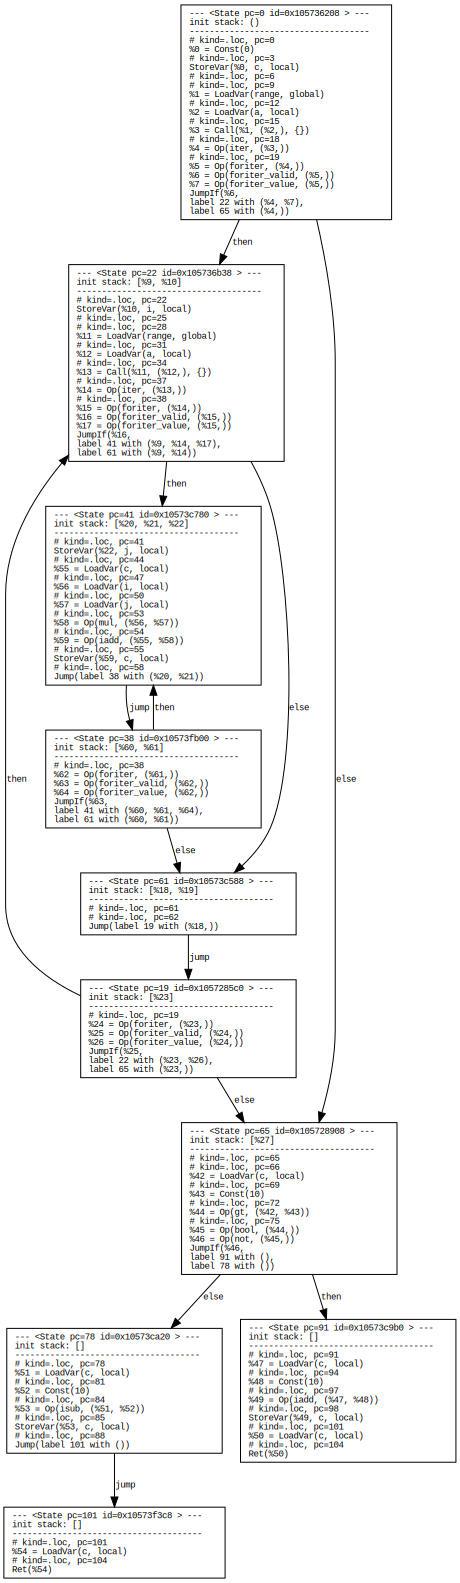

In [6]:
tracegraph.graphviz(view=False)

The above figure is the tracegraph. 

It is caleld a tracegraph because it is built from tracing the execution statically.  The execution is emulated (thus symbolic evaluation).  Each branch is considered and duplicated traces (State in the graph) are merged.  This technique implicitly performed the stack-to-register allocation by emulating the stack.

Notice that:

* Each basicblock explicitly defines the incoming values 
* Each jump/branch explicitly defines the outgoing values
    * There must be **at least** the same number of outgoing values than the number of incoming values of the target block.  Extra ones are dropped.  Their end-of-life is after the current block.
    

## Decompiling to Python code

And doing it without emulating an interpreter

In [7]:
import inspect
from codetrace import decompiler, decompiled_runtime, cfanalyze

An important component of the decompiler is the region tree.  A region is a single-entry, single-exit group of basicblocks.  The following code plots the tracegraph and group the basicblocks into regions.

A red box is the toplevel region.  A function is a region.
A green box is a trivial region, a single member region.
A blue box is non-trivial region.

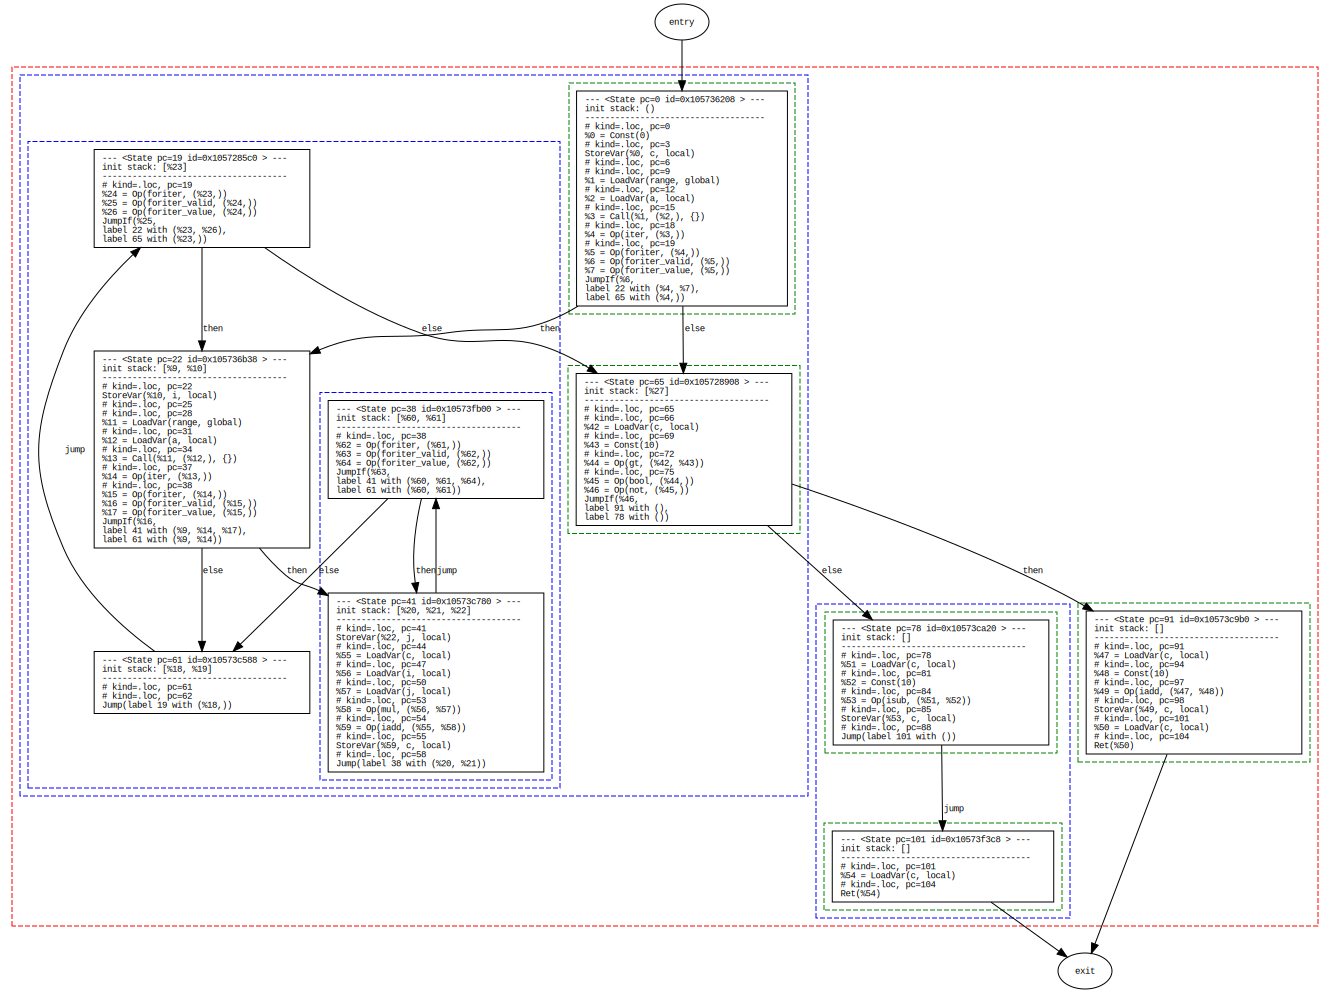

In [8]:
cfa = cfanalyze.CFA(tracegraph)  # controlflow analysis
cfa.gv_region_tree(tracegraph, view=False)

The following emits a python code that performs the same computation as the source function.  Notice that:

* loops are represented as `while` loops and the nesting is persisted.
* The trailing `if-else` structure is preserved at the end (as two `if` branches).

This makes the generated source more readable.

(note: C code generation is possible from here)

In [9]:
sig = inspect.signature(foo)

code = decompiler.decompile(tracegraph, cfa, foo.__name__, sig)
print(code)

def foo(a):
    __pred__0_4386415112 = False
    __pred__78_4386441760 = False
    __pred__101_4386452424 = False
    __pred__41_4386441088 = False
    __pred__65_4386359560 = False
    __pred__38_4386454272 = False
    __pred__22_4386417464 = False
    __pred__61_4386440584 = False
    __pred__91_4386441648 = False
    __pred__19_4386358720 = False
    __pred__0_4386415112 = True
    assert __pred__0_4386415112 , '__pred__0_4386415112 not enabled'
    assert __pred__0_4386415112 , '__pred__0_4386415112 not enabled'
    assert __pred__0_4386415112 , '__pred__0_4386415112 not enabled'
    # <State pc=0 id=0x105736208 >
    __pred__0_4386415112 = False
    __var__0 = 0
    c = __var__0
    __var__1 = range
    __var__2 = a
    __var__3 = __var__1(__var__2)
    __var__4 = iter(__var__3)
    __var__5 = __rt__.foriter(__var__4)
    __var__6 = __rt__.foriter_valid(__var__5)
    __var__7 = __rt__.foriter_value(__var__5)
    if __var__6:
        __pred__22_4386417464 = True
        [__var__9, 

Load the regenerated function into the interpreter.
Note: it uses the `decompiled_runtime` which is necessary to emulate `foriter` instructions.

In [10]:
myglobals = {'__rt__': decompiled_runtime}
exec(code, myglobals)
myfoo = myglobals['foo']

The regenerated function produces the same answer

In [11]:
print([foo(x) for x in range(20)])
print([myfoo(x) for x in range(20)])

[10, 10, 11, 19, 26, 90, 215, 431, 774, 1286, 2015, 3015, 4346, 6074, 8271, 11015, 14390, 18486, 23399, 29231]
[10, 10, 11, 19, 26, 90, 215, 431, 774, 1286, 2015, 3015, 4346, 6074, 8271, 11015, 14390, 18486, 23399, 29231]


## Constant propagation pass

The constant propagation pass is an evaluation pass on the tracegraph.  
The pass performs the following: 

* emulates the function execution symbolically;
* records constant evaluation and computes trivial constant expression; and,
* creates a new tracegraph. 

Dead branch pruning is a side-effect of the process.  Dead branches are simplify never visited.

In [12]:
from codetrace.passes.constprop import constant_propagation

### Collapsing dead branches

In [13]:
def fold_ifelse():
    a = 1
    if a > 0:
        a -= 2
    else:
        a += 3
    return a

### The original tracegraph

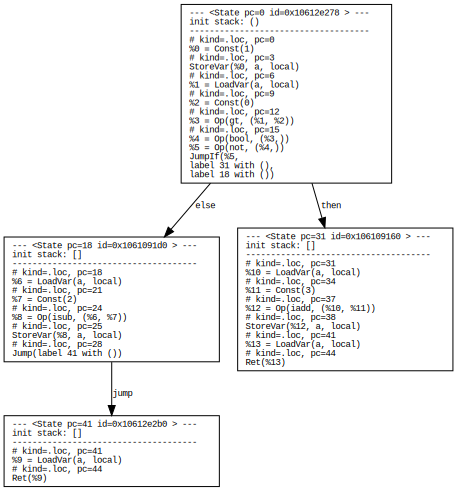

In [14]:
tracegraph = symeval.symbolic_evaluate(list(bytecode.disassemble(fold_ifelse)))
tracegraph.graphviz(view=False)

### Perform constant propagation

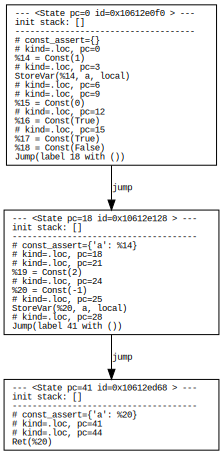

In [15]:
rewritten = constant_propagation(tracegraph)
rewritten.graphviz(view=False)

### Simplified

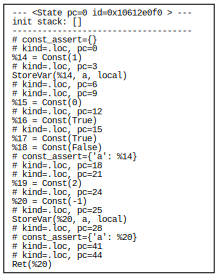

In [16]:
rewritten.simplify()
rewritten.graphviz(view=False)

### Decompile

In [17]:
def run_decompiler(fn, tracegraph):
    cfa = cfanalyze.CFA(tracegraph)
    sig = inspect.signature(fn)
    code = decompiler.decompile(tracegraph, cfa, fn.__name__, sig)
    myglobals = {'__rt__': decompiled_runtime}
    exec(code, myglobals)
    return code, myglobals[fn.__name__]

In [18]:
code, new_fold_ifelse = run_decompiler(fold_ifelse, rewritten)
print(code)

def fold_ifelse():
    __pred__0_4396867824 = False
    __pred__0_4396867824 = True
    assert __pred__0_4396867824 , '__pred__0_4396867824 not enabled'
    # <State pc=0 id=0x10612e0f0 >
    __pred__0_4396867824 = False
    __var__14 = 1
    a = __var__14
    __var__15 = 0
    __var__16 = True
    __var__17 = True
    __var__18 = False
    __var__19 = 2
    __var__20 = -1
    a = __var__20
    return __var__20
    raise AssertionError("unreachable")



### Verify regenerated function

In [19]:
print(fold_ifelse())
print(new_fold_ifelse())

-1
-1


## Collapsing loops

In [20]:
def fold_loop(a, b):
    c = 3
    for i in range(b):  # note that `b` is not a constant
        if c == 3:
            return a

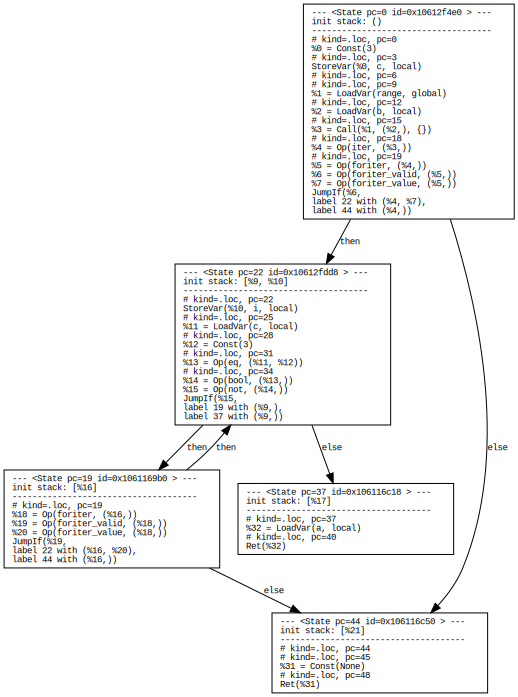

In [21]:
tracegraph = symeval.symbolic_evaluate(list(bytecode.disassemble(fold_loop)))
tracegraph.graphviz(view=False)

### Perform constant propagation

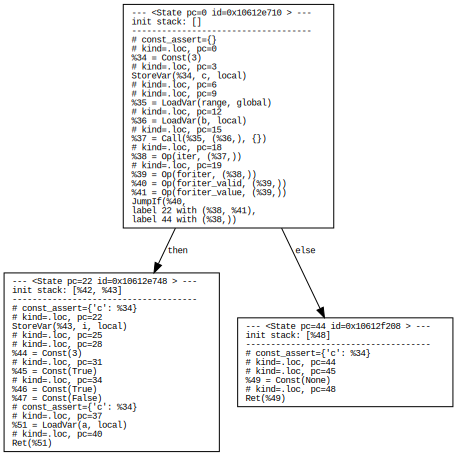

In [22]:
rewritten = constant_propagation(tracegraph)
rewritten.simplify()
rewritten.graphviz(view=False)

The function can only have two outcomes:

* If the loop is taken, always output `a`; 
* else return `None`.

### Decompile

In [23]:
code, new_fold_loop = run_decompiler(fold_loop, rewritten)
print(code)

def fold_loop(a, b):
    __pred__44_4396872200 = False
    __pred__0_4396869392 = False
    __pred__22_4396869448 = False
    __pred__0_4396869392 = True
    assert __pred__0_4396869392 , '__pred__0_4396869392 not enabled'
    assert __pred__0_4396869392 , '__pred__0_4396869392 not enabled'
    # <State pc=0 id=0x10612e710 >
    __pred__0_4396869392 = False
    __var__34 = 3
    c = __var__34
    __var__35 = range
    __var__36 = b
    __var__37 = __var__35(__var__36)
    __var__38 = iter(__var__37)
    __var__39 = __rt__.foriter(__var__38)
    __var__40 = __rt__.foriter_valid(__var__39)
    __var__41 = __rt__.foriter_value(__var__39)
    if __var__40:
        __pred__22_4396869448 = True
        [__var__42, __var__43] = [__var__38, __var__41]
    else:
        __pred__44_4396872200 = True
        [__var__48] = [__var__38]
    if __pred__44_4396872200:
        assert __pred__44_4396872200 , '__pred__44_4396872200 not enabled'
        # <State pc=44 id=0x10612f208 >
        __pred__44_4

### Verify

In [24]:
print(fold_loop(123, 3), fold_loop(123, 0))
print(new_fold_loop(123, 3), new_fold_loop(123, 0))

123 None
123 None


## Type Inference

Extending from the constant propagation pass, the type-inference pass uses knowledge of variable types to help constant propagation.

(The implementation is very basic currently.  It does not have type information of operations, yet.)

In [25]:
from codetrace.passes.typeinfer import type_inference

In [26]:
def fold_ifelse(a):
    if isinstance(a, int):
        c = a + 1
    else:
        c = a + 2
    return c + 3

type informations

In [27]:
typeinfos = {'a': int}

### Perform type inference

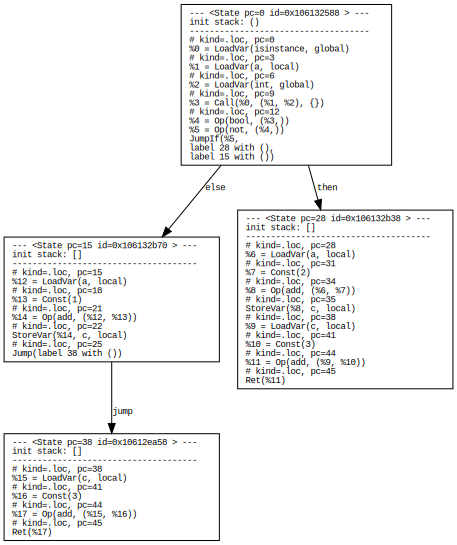

In [28]:
tracegraph = symeval.symbolic_evaluate(list(bytecode.disassemble(fold_ifelse)))
tracegraph.graphviz(view=False)

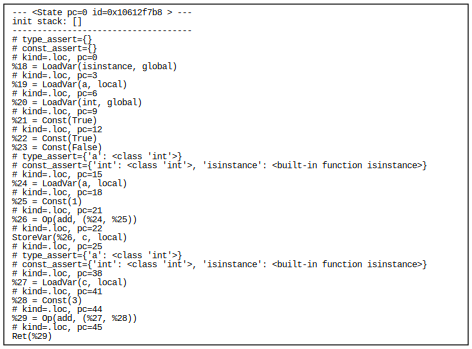

In [29]:
rewritten = type_inference(tracegraph, typeinfos)
rewritten.simplify()
rewritten.graphviz(view=False)

Since we know the type of ``a``, we can collapse the branch when the ``isinstance(a, int)`` evaluates False.

### Decompile

In [30]:
code, new_fold_ifelse = run_decompiler(fold_ifelse, rewritten)
print(code)

def fold_ifelse(a):
    __pred__0_4396873656 = False
    __pred__0_4396873656 = True
    assert __pred__0_4396873656 , '__pred__0_4396873656 not enabled'
    # <State pc=0 id=0x10612f7b8 >
    __pred__0_4396873656 = False
    __var__18 = isinstance
    __var__19 = a
    __var__20 = int
    __var__21 = True
    __var__22 = True
    __var__23 = False
    __var__24 = a
    __var__25 = 1
    __var__26 = __var__24 + __var__25
    c = __var__26
    __var__27 = c
    __var__28 = 3
    __var__29 = __var__27 + __var__28
    return __var__29
    raise AssertionError("unreachable")



### Verify

In [31]:
print([fold_ifelse(x) for x in range(10)])
print([new_fold_ifelse(x) for x in range(10)])

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
